In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.4 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Import the Dataset
To obtain 25 equidistant data points, we interpolate the first 10,000 data points of $u, v,$ and $\theta$ spanning from time 0 to 100.

In [34]:
import pandas as pd
raw = pd.read_csv('sbm1.csv')
raw = raw[0:10000]
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

Text(0, 0.5, 'y')

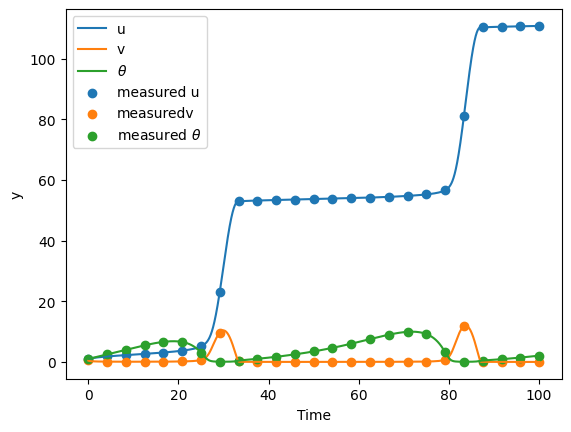

In [35]:
t_int = np.linspace(0,100,25)
u_int = np.interp(t_int, observe_t.values.reshape((-1)), u_ext.values.reshape((-1)))
v_int = np.interp(t_int, observe_t.values.reshape((-1)), v_ext.values.reshape((-1)))
theta_int = np.interp(t_int, observe_t.values.reshape((-1)), theta_ext.values.reshape((-1)))

plt.plot(observe_t, u_ext, label="u")
plt.plot(observe_t, v_ext, label="v")
plt.plot(observe_t, theta_ext, label= r"$\theta$")

plt.scatter(t_int, u_int ,label="measured u")
plt.scatter(t_int, v_int, label="measuredv")
plt.scatter(t_int, theta_int, label= r"measured $\theta$")

plt.legend()
plt.xlabel('Time')
plt.ylabel('y')

In [36]:
arr = t_int
observe_t = arr.reshape((-1, 1))
u_ext = u_int.reshape((-1, 1))
v_ext = v_int.reshape((-1, 1))
theta_ext = theta_int.reshape((-1, 1))

In [37]:
observe_y0 = dde.icbc.PointSetBC(observe_t, u_ext, component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, v_ext, component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, theta_ext, component=2)

# Formulation of the Problem

\begin{align*}
\frac{{d\tilde{u}}}{{d\tilde{t}}} &= \tilde{v} \\
\frac{{d\tilde{v}}}{{d\tilde{t}}} &= \kappa(v_o \tilde{t} - \tilde{u}) - \alpha(f_o + a \log \tilde{v} + b \log \tilde{\theta}) \\
\frac{{d\tilde{\theta}}}{{d\tilde{t}}} &= -\tilde{v}\tilde{\theta} \log(\tilde{v}\tilde{\theta})
\end{align*}

We aim to predict the solutions of $\tilde{u}$, $\tilde{v}$, and $\tilde{\theta}$, given their measurements. We can write $MSE$ as follows:

\begin{align*}
\text{MSE} &= \text{MSE}_R + \text{MSE}_B + \text{MSE}_m \\
\text{MSE}_R &= \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \left( \dot{u}(t_i, \varphi) - v(t_i, \varphi) \right) \right|^2  + \\
&\quad \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \dot{v}(t_i, \varphi) - \kappa(v_0 t_i - u(t_i, \varphi)) + \alpha(f_o + a \ln v(t_i, \varphi) + b \ln \theta(t_i, \varphi)) \right|^2 + \\
&\quad  \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \dot{\theta}(t_i, \varphi) + v(t_i, \varphi) \theta(t_i, \varphi) \log \left( v(t_i, \varphi) \theta(t_i, \varphi) \right) \right|^2
\end{align*}


\begin{align*}
\text{MSE}_B = \frac{1}{N_B} \sum_{i=1}^{N_B} \left| u(t_i=0, \varphi) - u_o \right|^2 + \frac{1}{N_B} \sum_{i=1}^{N_B} \left| v(t_i=0, \varphi) - v_o \right|^2 + \frac{1}{N_B} \sum_{i=1}^{N_B} \left| \theta(t_i=0, \varphi) - \theta_o \right|^2
\end{align*}

\begin{align*}
\text{MSE}_m = \frac{1}{N_m} \sum_{i=1}^{N_m} \left| u(t_i, \varphi) - u^*(t_i) \right|^2 + \frac{1}{N_m} \sum_{i=1}^{N_m} \left| v(t_i, \varphi) - v^*(t_i) \right|^2 + \frac{1}{N_m} \sum_{i=1}^{N_m} \left| \theta(t_i, \varphi) - \theta^*(t_i) \right|^2
\end{align*}

In [3]:
alpha = 9.81
kappa = 0.25
v0 = 1
f0 = 0.2
a = 0.2
b = 0.3

In [28]:
def ode_system(x, y):
  u = y[:, 0:1]
  v = y[:, 1:2]
  theta = y[:, 2:3]

  du_t = dde.grad.jacobian(y, x, i=0)
  dv_t = dde.grad.jacobian(y, x, i=1)
  dtheta_t = dde.grad.jacobian(y, x, i=2)

  return     [
      du_t - tf.clip_by_value(v,0,13) ,
      dv_t - kappa * (v0 * x - u) + alpha * (f0 + a * tf.math.log(tf.clip_by_value(v,0,13)) + b * tf.math.log(tf.clip_by_value(theta,0,11))),
      dtheta_t + (tf.clip_by_value(v,0,13) * tf.clip_by_value(theta,0,11) * tf.math.log(tf.clip_by_value(v,0,13) * tf.clip_by_value(theta,0,11)))]


# Compile and Train Model

The model has 6 layers of 64 neurons. We input time and output 3 neurons: $\tilde{u}$, $\tilde{v}$, and $\tilde{\theta}$. Number of training residual points is 20,000. We train for 50,000 iterations.

In [4]:
geom = dde.geometry.TimeDomain(0, 100)

In [29]:
data = dde.data.PDE(geom, ode_system, [observe_y0, observe_y1, observe_y2], 20000, 0, num_test = 3000)

In [30]:
layer_size = [1] + [64] * 6 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [31]:
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]

    return tf.concat(
        [y1 * tf.tanh(t) + 1, y2 * tf.tanh(t) + 0.5, y3 * tf.tanh(t) + 1 ], axis=1
    )

In [32]:
net.apply_output_transform(output_transform)

In [33]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.0001,
    loss_weights=[1,1,1,1,1,1]
    )

losshistory, train_state = model.train(epochs=50000)

Compiling model...
Building feed-forward neural network...
'build' took 0.102912 s

'compile' took 1.226193 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.35e-01, 2.03e+02, 1.27e-01, 3.54e+03, 8.42e+00, 1.94e+01]    [9.35e-01, 2.03e+02, 1.27e-01, 3.54e+03, 8.42e+00, 1.94e+01]    []  
1000      [3.33e-01, 4.74e+01, 4.36e+00, 2.22e+03, 8.73e+00, 9.90e+00]    [3.28e-01, 4.74e+01, 4.36e+00, 2.22e+03, 8.73e+00, 9.90e+00]    []  
2000      [5.81e-01, 3.62e+01, 3.33e+00, 1.79e+03, 8.74e+00, 9.15e+00]    [5.81e-01, 3.61e+01, 3.33e+00, 1.79e+03, 8.74e+00, 9.15e+00]    []  
3000      [8.41e-01, 2.78e+01, 2.42e+00, 1.44e+03, 8.71e+00, 8.63e+00]    [8.41e-01, 2.78e+01, 2.42e+00, 1.44e+03, 8.71e+00, 8.63e+00]    []  
4000      [9.63e-01, 2.18e+01, 1.71e+00, 1.16e+03, 8.22e+00, 8.13e+00]    [9.63e-01, 2.18e+01, 1.71e+00, 1.16e+03, 8.22e+00, 8.13e+00]    []  
5000 

# Prediction and Plotting

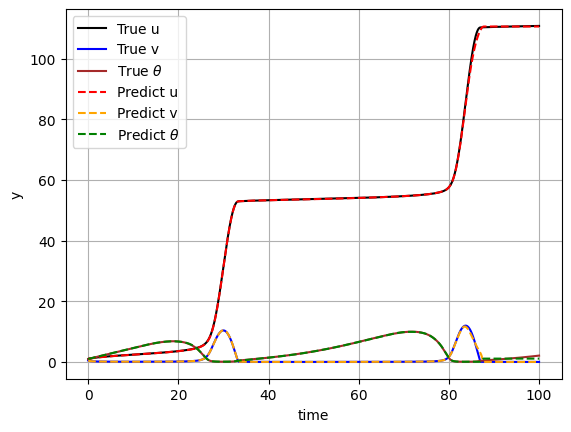

In [43]:
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

plt.figure()
plt.xlabel("time")
plt.ylabel("y")

plt.plot(observe_t, u_ext, color="black", label="True u")
plt.plot(observe_t, v_ext, color="blue", label="True v")
plt.plot(observe_t, theta_ext, color="brown", label=r'True $\theta$')

t = np.linspace(0, 100, 10000)
t = t.reshape(10000, 1)
sol_pred = model.predict(t)
u_pred = sol_pred[:, 0:1]
v_pred = sol_pred[:, 1:2]
theta_pred = sol_pred[:, 2:3]

plt.plot(t, u_pred, color="red", linestyle="dashed", label="Predict u")
plt.plot(t, v_pred, color="orange", linestyle="dashed", label="Predict v")
plt.plot(t, theta_pred, color="green", linestyle="dashed", label=r"Predict $\theta$")
plt.legend()
# plt.xlim([0,40])
# plt.ylim([0,10])
plt.grid()
plt.savefig('pred.png')
plt.show()
